In [8]:
import numpy as np
import os.path
import pandas
import matplotlib
import scipy.signal

%matplotlib inline
import matplotlib.pyplot as plt

data_dir = "/Users/humphreys/Documents/IDrive-Sync/Work/Delft/Projects/Notebooks/Analysis/Freq_analysis_and_Allan_deviation/16_05_31_InterferometricStability"


## Interferometric trace

In [9]:
file_name = "16_05_31_InterferometricStability.csv"

filename = os.path.join(data_dir,file_name)

scope = 'Slow' #TODO Get better scope names

if scope == 'Fast':
    # To open files from the fast scope (CSV)

    file = open(filename)
    for x in range(9):
            line = file.readline()
            if "HResolution" in line:
                TimeRes = float(line[-18:-1])
    file.close()
    
    subdiv = 1            
    data = pandas.read_csv(os.path.join(data_dir,filename),header=None,skiprows = 15)
    data = data.drop([0,2],1)
    data = data.rolling(window = 100).mean()
    data = data.as_matrix()[100:-100:subdiv]
    
    TimeRes = TimeRes*subdiv
    t = TimeRes*np.arange(len(vals))
    
elif scope == 'Slow':
    data = pandas.read_csv(os.path.join(data_dir,filename),header=0,skiprows = 0,nrows=1)
    TimeRes = data['Increment'][0]

    subdiv = 1            
    data = pandas.read_csv(os.path.join(data_dir,filename),header=None,skiprows = 2)
    data = data.drop([0,2],1)
    data = data.rolling(window = 100).mean()
    data = data.as_matrix()[100:-100:subdiv]

    TimeRes = TimeRes*subdiv
    t = TimeRes*np.arange(len(vals))


NormMax = np.amax(data); NormMin = np.amin(data)
data = (np.array(data)-(NormMax+NormMin)/2)*(2./(NormMax-NormMin)) 

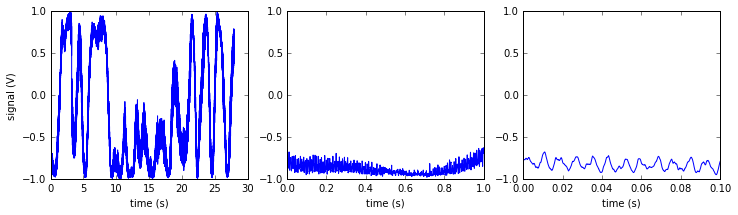

In [10]:
fig = plt.figure(figsize=(12, 3))

ax = plt.subplot(1,3,1)
plt.plot(t,data)
plt.xlabel('time (s)')
plt.ylabel('signal (V)')

ax = plt.subplot(1,3,2)
        
plt.plot(t,data)
plt.xlim([0,1])
plt.xlabel('time (s)')

ax = plt.subplot(1,3,3)        
plt.plot(t,data)
plt.xlim([0,0.1])
plt.xlabel('time (s)')


plt.show()
plt.close(fig)

freq: 0, height: 0.2179
freq: 121, height: 0.0039
freq: 188, height: 0.0005
freq: 169, height: 0.0001
freq: 80, height: 0.0001
freq: 376, height: 0.0001
freq: 95, height: 0.0000
freq: 358, height: 0.0000
freq: 159, height: 0.0000
freq: 10, height: 0.0000


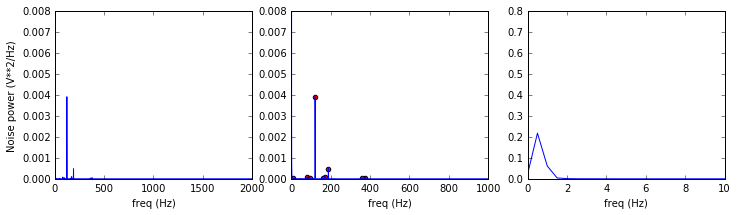

In [11]:
freq_pow, power = scipy.signal.welch(data, axis = 0, fs = 1/TimeRes,nperseg = 100000)

fig = plt.figure(figsize=(12, 3))

from detect_peaks import detect_peaks

peaks = detect_peaks(np.squeeze(power),mpd=3/(freq_pow[1]-freq_pow[0]))
peaks = peaks[np.argsort(np.squeeze(power[peaks]))][::-1]
peaks = peaks[0:10]

for freq,pow in zip(freq_pow[peaks], power[peaks]):
    print 'freq: %d, height: %.4f' % (freq, pow)
    
ax = plt.subplot(1,3,1)
plt.plot(freq_pow,power)
plt.xlim([0,2000])
plt.ylim([0,0.008])
plt.xlabel('freq (Hz)')
plt.ylabel('Noise power (V**2/Hz)')

ax = plt.subplot(1,3,2)
        
plt.plot(freq_pow,power)
plt.xlim([0,1000])
plt.ylim([0,0.008])
plt.xlabel('freq (Hz)')
plt.scatter(freq_pow[peaks],power[peaks],c='r')

ax = plt.subplot(1,3,3) 
plt.plot(freq_pow,power)
plt.xlim([0,10])
plt.ylim([0,0.8])
plt.xlabel('freq (Hz)')


plt.show()
plt.close(fig)

In [12]:
min_freq = 100
max_freq = 1000

min_ind = np.argmin(np.abs(freq_pow-min_freq))
max_ind = np.argmin(np.abs(freq_pow-max_freq))

pow_int = scipy.integrate.trapz(power[min_ind:max_ind],freq_pow[min_ind:max_ind],axis=0)
full_pow = scipy.integrate.trapz(power,freq_pow,axis=0)

dc_freq = 3
dc_ind = np.argmin(np.abs(freq_pow-dc_freq))

pow_dc = scipy.integrate.trapz(power[0:dc_ind],freq_pow[0:dc_ind],axis=0)

rel_dc_pow = pow_dc/full_pow
print 'Relative DC power: %.3f' %rel_dc_pow

rel_pow = pow_int/full_pow
print 'Relative in-band power: %.3f' %rel_pow

rel_band_pow = pow_int/(full_pow-pow_dc)
print 'Relative in-band power (minus DC): %.3f' %rel_band_pow

print 'Full noise power: %.3e' %full_pow

print 'DC noise power: %.3e' %pow_dc


Relative DC power: 0.958
Relative in-band power: 0.037
Relative in-band power (minus DC): 0.870
Full noise power: 1.541e-01
DC noise power: 1.476e-01


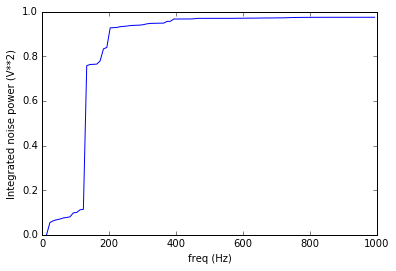

In [13]:
freq_bin = 10.
min_freq = 3
max_freq = 1000

freq_rate = freq_pow[1]- freq_pow[0]
ind_bin = int(freq_bin/freq_rate)
min_ind = np.argmin(np.abs(freq_pow-min_freq))
max_ind = np.argmin(np.abs(freq_pow-max_freq))

cum_points = np.arange(min_ind,max_ind,ind_bin)

cum_freqs = freq_pow[cum_points[1:]]
cum_pow = np.zeros(np.shape(cum_freqs))

for x in range(len(cum_pow)-1):
    cum_pow[x+1] = cum_pow[x] + scipy.integrate.trapz(power[cum_points[x]:cum_points[x+1]],freq_pow[cum_points[x]:cum_points[x+1]],axis=0)

cum_pow = cum_pow/(full_pow-pow_dc)

fig = plt.figure()
ax = plt.subplot() 
plt.plot(cum_freqs,cum_pow)
plt.xlabel('freq (Hz)')
plt.ylabel('Integrated noise power (V**2)')

plt.show()
plt.close(fig)

### Just to check, lets do a FFT

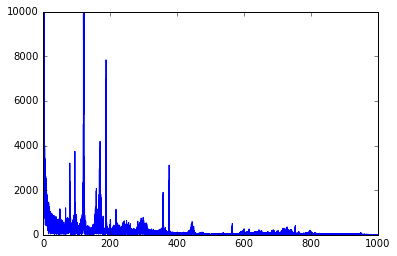

In [14]:
### fast fourier transform
from scipy.fftpack import fft

fft = fft(data,axis=0)
freq = np.fft.fftfreq(t.shape[-1],TimeRes)

N = len(fft)
fft = fft[0:N/2]
freq = freq[0:N/2]

fig = plt.figure()
ax = plt.subplot()
        
plt.plot(freq,np.abs(fft))
plt.xlim([0,1000])
plt.ylim([0,10000])
plt.show()
plt.close(fig)